# Предобработка

In [54]:
# Нейронные сети
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import metrics
import random
from sklearn.metrics import confusion_matrix

# Предобработка данных
import pandas as pd
import numpy as np
import keras
from keras.utils import image_dataset_from_directory

In [55]:
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions

In [3]:
path = r'prepared_dataset'
dataset = image_dataset_from_directory(path,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode='rgb',
                                       batch_size=int(9415 * 0.8),
                                       image_size=(256,256),
                                       shuffle=True,
                                       seed=239
                                       )

Found 9415 files belonging to 4 classes.


In [4]:
for i, element in enumerate(dataset):
  if i == 0:
    X_train, y_train = np.array(element[0]), np.array(element[1])
  elif i == 1:
    X_test, y_test = np.array(element[0]), np.array(element[1])

# Модель

In [6]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [5]:
base_model = VGG19(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
) 
base_model.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = preprocess_input(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Dense(160, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(160, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

Epoch 1/6
113/113 [==============================] - 5693s 50s/step - loss: 1.0214 - accuracy: 0.6021 - val_loss: 0.6080 - val_accuracy: 0.7759
Epoch 2/6
113/113 [==============================] - 5642s 50s/step - loss: 0.6963 - accuracy: 0.7302 - val_loss: 0.5088 - val_accuracy: 0.8083
Epoch 3/6
113/113 [==============================] - 5624s 50s/step - loss: 0.5884 - accuracy: 0.7771 - val_loss: 0.4592 - val_accuracy: 0.8359
Epoch 4/6
113/113 [==============================] - 5624s 50s/step - loss: 0.5502 - accuracy: 0.7853 - val_loss: 0.4365 - val_accuracy: 0.8370
Epoch 5/6
113/113 [==============================] - 5749s 51s/step - loss: 0.5141 - accuracy: 0.8023 - val_loss: 0.4735 - val_accuracy: 0.8157
Epoch 6/6
113/113 [==============================] - 5695s 51s/step - loss: 0.4842 - accuracy: 0.8147 - val_loss: 0.4274 - val_accuracy: 0.8497


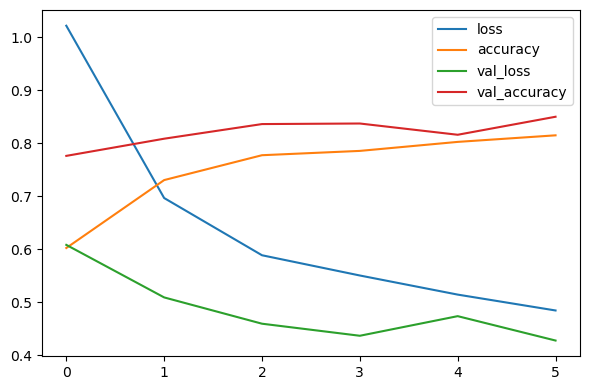

In [7]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_history = model.fit(X_train, y_train, validation_split=0.25, epochs=6, batch_size=50)

pd.DataFrame(model_history.history).plot(figsize=(6, 4))
plt.tight_layout()
plt.show()

In [8]:
scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)

59/59 [==============================] - 1434s 24s/step - loss: 0.4153 - accuracy: 0.8524
[0.4153144955635071, 0.8523632287979126]


# Проверка качества обученной модели

In [9]:
y_pred = model.predict(X_test)

59/59 [==============================] - 1955s 33s/step


In [12]:
a1 = []
a2 = []
for a in y_test:
    a1.append(np.argmax(a, axis=-1))
for a in y_pred:
    a2.append(np.argmax(a, axis=-1))

matrix = confusion_matrix(a1, a2)
precision, recall, F1_score = [], [], []
for i in range(len(matrix)):
    precision.append(matrix[i, i] / sum(matrix[:, i]))
    recall.append(matrix[i, i] / sum(matrix[i, :]))
    F1_score.append(2 * precision[i] * recall[i] / (precision[i] + recall[i]))
    
labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
print(' ' * 10, 'COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia', sep='   ')

print('Precision', end='  ')
for i in range(len(precision)):
    print(f'{str(round(precision[i], 3)) : >7}', end='     ')
print()

print('Recall', end='     ')
for i in range(len(recall)):
    print(f'{str(round(recall[i], 3)) : >7}', end='     ')
print()
    
print('F1-score', end='   ')
for i in range(len(F1_score)):
    print(f'{str(round(F1_score[i], 3)) : >7}', end='     ')
print()

             COVID   Lung Opacity   Normal   Viral Pneumonia
Precision    0.945       0.782       0.796       0.971     
Recall        0.78       0.887       0.829       0.971     
F1-score     0.855       0.831       0.812       0.971     


In [13]:
matrix

array([[416,  57,  59,   1],
       [ 10, 469,  50,   0],
       [ 12,  74, 450,   7],
       [  2,   0,   6, 270]], dtype=int64)

# GradCam

In [14]:
images_ind = []
for k in range(0, 5):
    for i in range(len(y_test) - 1, -1, -1):
        if np.where(y_test[i] == 1)[0] == k:
            print(i)
            images_ind.append(i)
            break

1874
1878
1880
1882


In [42]:
img_size = (256, 256)
last_conv_layer_name = "block5_conv4"

In [90]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = keras.models.Model([model.inputs], [base_model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(preds.shape)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [91]:
result_heatmap = []

for i in images_ind:
    img_array = np.expand_dims(X_test[i], axis = 0)
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    print(preds)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    result_heatmap.append(heatmap)

1/1 [==============================] - 1s 848ms/step
[[0.94314736 0.04669278 0.00736832 0.00279158]]


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "block1_conv1". The following previous layers were accessed without issue: []

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path = "cam.jpg", alpha = 0.002):
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("winter")     #    winter    PiYG_r
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    display(Image(cam_path))


for i in range(len(images_ind)):
    save_and_display_gradcam(X_test[images_ind[i]], result_heatmap[i])